In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import rasterio as rio
import xarray as xr
from scipy import ndimage
from netCDF4 import Dataset
from landlab import RasterModelGrid
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser

## Coupling with Landlab components

This notebook gives one *very simplistic* example for how Ku can be used alongside landscape geomorphology models. We will use the active layer depth results from Ku to drive a depth-dependent hillslope diffusion model over the Eight Mile Lake study site.

The Eight Mile Lake DEM is a subset of the 2m ArcticDEM from the Polar Geospatial Center (see: https://www.pgc.umn.edu/data/arcticdem/). To run the following code cells, put the DEM of your choice in the data/ directory, and change the file names and paths accordingly. Alternatively, explore idealized examples by ignoring this section and altering the grid's topographic elevation field directly.

In [4]:
# Load a DEM
with rio.open('/data/eightmile-lake-dem-cropped.tif') as f:
    data = f.read(1)
    
    # ArcticDEM tiles are rotated, so let's rotate it back
    fine_dem = ndimage.rotate(data[:3280, :4530], 90)

From this point onwards, the computational requirements of almost every step will scale with the size of this DEM. To save time, we can rescale it with typical image processing tools. I'll use xarray's coarsen() method here.

In [5]:
# Coarsen the DEM 
xr_dem = xr.DataArray(fine_dem)
scale = 10
dem = xr_dem.coarsen(dim_0 = scale, dim_1 = scale).mean()

When visualizing DEMs, it is often helpful to use matplotlib's LightSource.hillshade(). For a bit of fun, mess with directional lighting using the 'azdeg' argument.

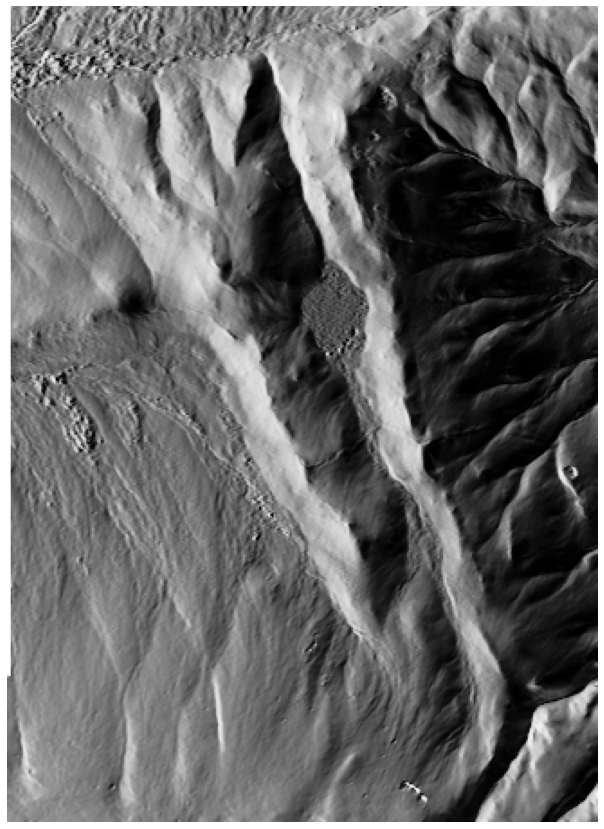

In [10]:
# Show the DEM
fig, ax = plt.subplots(figsize = (15, 15))

ls = LightSource(azdeg = 90, altdeg = 35)
shaded_dem = ls.hillshade(np.array(dem))

ax.imshow(shaded_dem, cmap = 'Greys')
plt.axis('off')
plt.show()

Next, we need to load the output files from Ku. If you haven't already completed a Ku model run, do that before running the following cells. Here, we're going to focus on depth-dependent diffusion, so we will only need the active layer thickness output.

In [13]:
# First, load the netCDF4 file
alt_nc = Dataset('./outputs/eightmile-ALT.nc')

# Then, extract a time series of the active layer thickness data
alt = alt_nc.variables['data'][:,0,0]

# Set any negative values to NaN
alt[np.where(alt < 0)] = np.nan

# Interpolate through the NaN values 
mask = np.isnan(alt)
alt[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), alt[~mask])

/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  """


Note that, you can ignore the warning that pops up here, code is still working properly below.

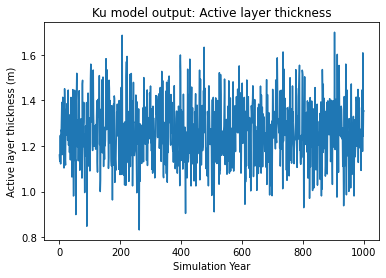

In [15]:

# Plot the active layer thickness dataset
plt.plot(alt)
plt.xlabel('Simulation Year')
plt.ylabel('Active layer thickness (m)')
plt.title('Ku model output: Active layer thickness')
plt.show()

### Landlab components

This is the simplest possible example, only using the Depth-Dependent Diffuser and no other inputs.

In [16]:
# First, make the model grid
grid = RasterModelGrid(dem.shape)

# Add fields for elevation and soil depth
z = grid.add_field('node', 'topographic__elevation', dem.astype(np.float64), units = 'm')
soilH = grid.add_field('node', 'soil__depth', np.full(grid.shape, alt[0], dtype = np.float64), units = 'm')
production = grid.add_zeros('soil_production__rate', at = 'node')

In [17]:
# Set parameter values
linear_diffusivity = 1e-2 # m^2 / yr
transport_decay_depth = 1 # m

In [18]:
# Initialize the Landlab component
ddiff = DepthDependentDiffuser(grid, linear_diffusivity, transport_decay_depth)

In [19]:
# Run the diffusion model

# Set the total runtime and time step size
nt = 1000 # years
dt = 1 # years

# Prepare an array for outputs
out = np.ndarray([nt, grid.shape[0], grid.shape[1]])

# The main loop
for i in range(nt):
    
    # If array lengths match, index alt directly with the loop index
    if nt == len(alt):
        soilH[:] = alt[i]
        
    # Else, rescale the indices to match the length of the ALT array
    else:
        idx = int((i / nt) * (len(alt)))
        soilH[:] = alt[idx]
    
    # Step the diffusion component
    ddiff.run_one_step(dt)
    
    # Save out the elevation grid
    out[i] = grid.field_values('node', 'topographic__elevation').reshape(grid.shape)
    
    if i % 100 == 0:
        print('Completed year ' + str(i))

Completed year 0
Completed year 100
Completed year 200
Completed year 300
Completed year 400
Completed year 500
Completed year 600
Completed year 700
Completed year 800
Completed year 900


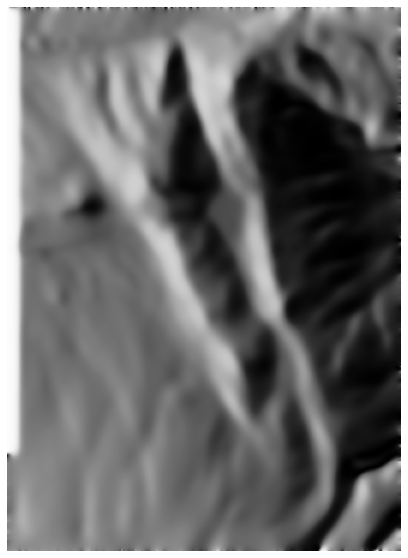

In [20]:
# Visualize the final landscape, after the model completed its run
# Note that there will be oddities around the edges, as we did not specify boundary conditions

fig, ax = plt.subplots(figsize = (10, 10))

ls = LightSource(azdeg = 90, altdeg = 35)
shaded_dem = ls.hillshade(out[-1])

ax.imshow(shaded_dem, cmap = 'Greys')
plt.axis('off')
plt.show()

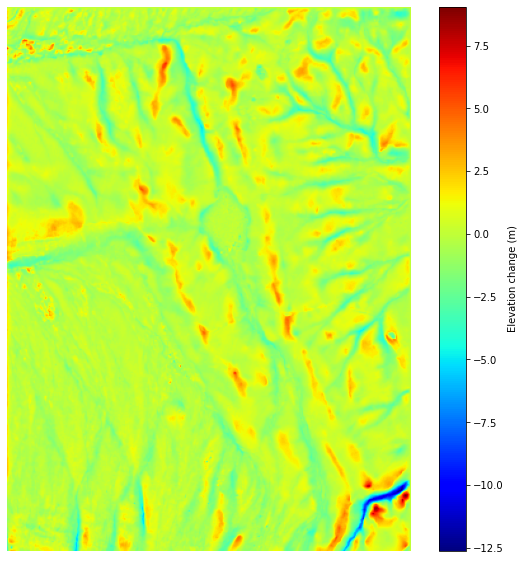

In [23]:
# Crop away the edges of the DEM
cropped = out[0,:-25,10:] - out[-1,:-25,10:]

# Then, visualize the difference from beginning to end at each grid cell
fig, ax = plt.subplots(figsize = (10, 10))
#im = ax.imshow(cropped, cmap = 'coolwarm')
im = ax.imshow(cropped, cmap = 'jet')
plt.axis('off')
fig.colorbar(im, ax = ax, label = 'Elevation change (m)')
plt.show()